Available serif fonts: ['DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'Liberation Serif', 'Liberation Serif', 'Liberation Serif', 'Liberation Serif']
Data overview:
Shape: (438, 14)

Columns:
['Mode', 'Year', 'Month', 'Ridership', 'Heat_Wave_Days', 'Heat_Wave_Events', 'Cold_Wave_Days', 'Cold_Wave_Events', 'Heavy_Precip_Days', 'Heavy_Precip_Events', 'Heavy_Snow_Days', 'Heavy_Snow_Events', 'Pandemic_Period', 'Pandemic_Period_Label']

Data types:
Mode                     object
Year                      int64
Month                     int64
Ridership                 int64
Heat_Wave_Days            int64
Heat_Wave_Events          int64
Cold_Wave_Days            int64
Cold_Wave_Events          int64
Heavy_Precip_Days         int64
Heavy_Precip_Events       int64
Heavy_Snow_Days           int64
Heavy_Snow_Events         int64
Pandemic_Period          object
Pandemic_Period_Label     int64
dtype: object

Missing values:
Mode                     0
Year

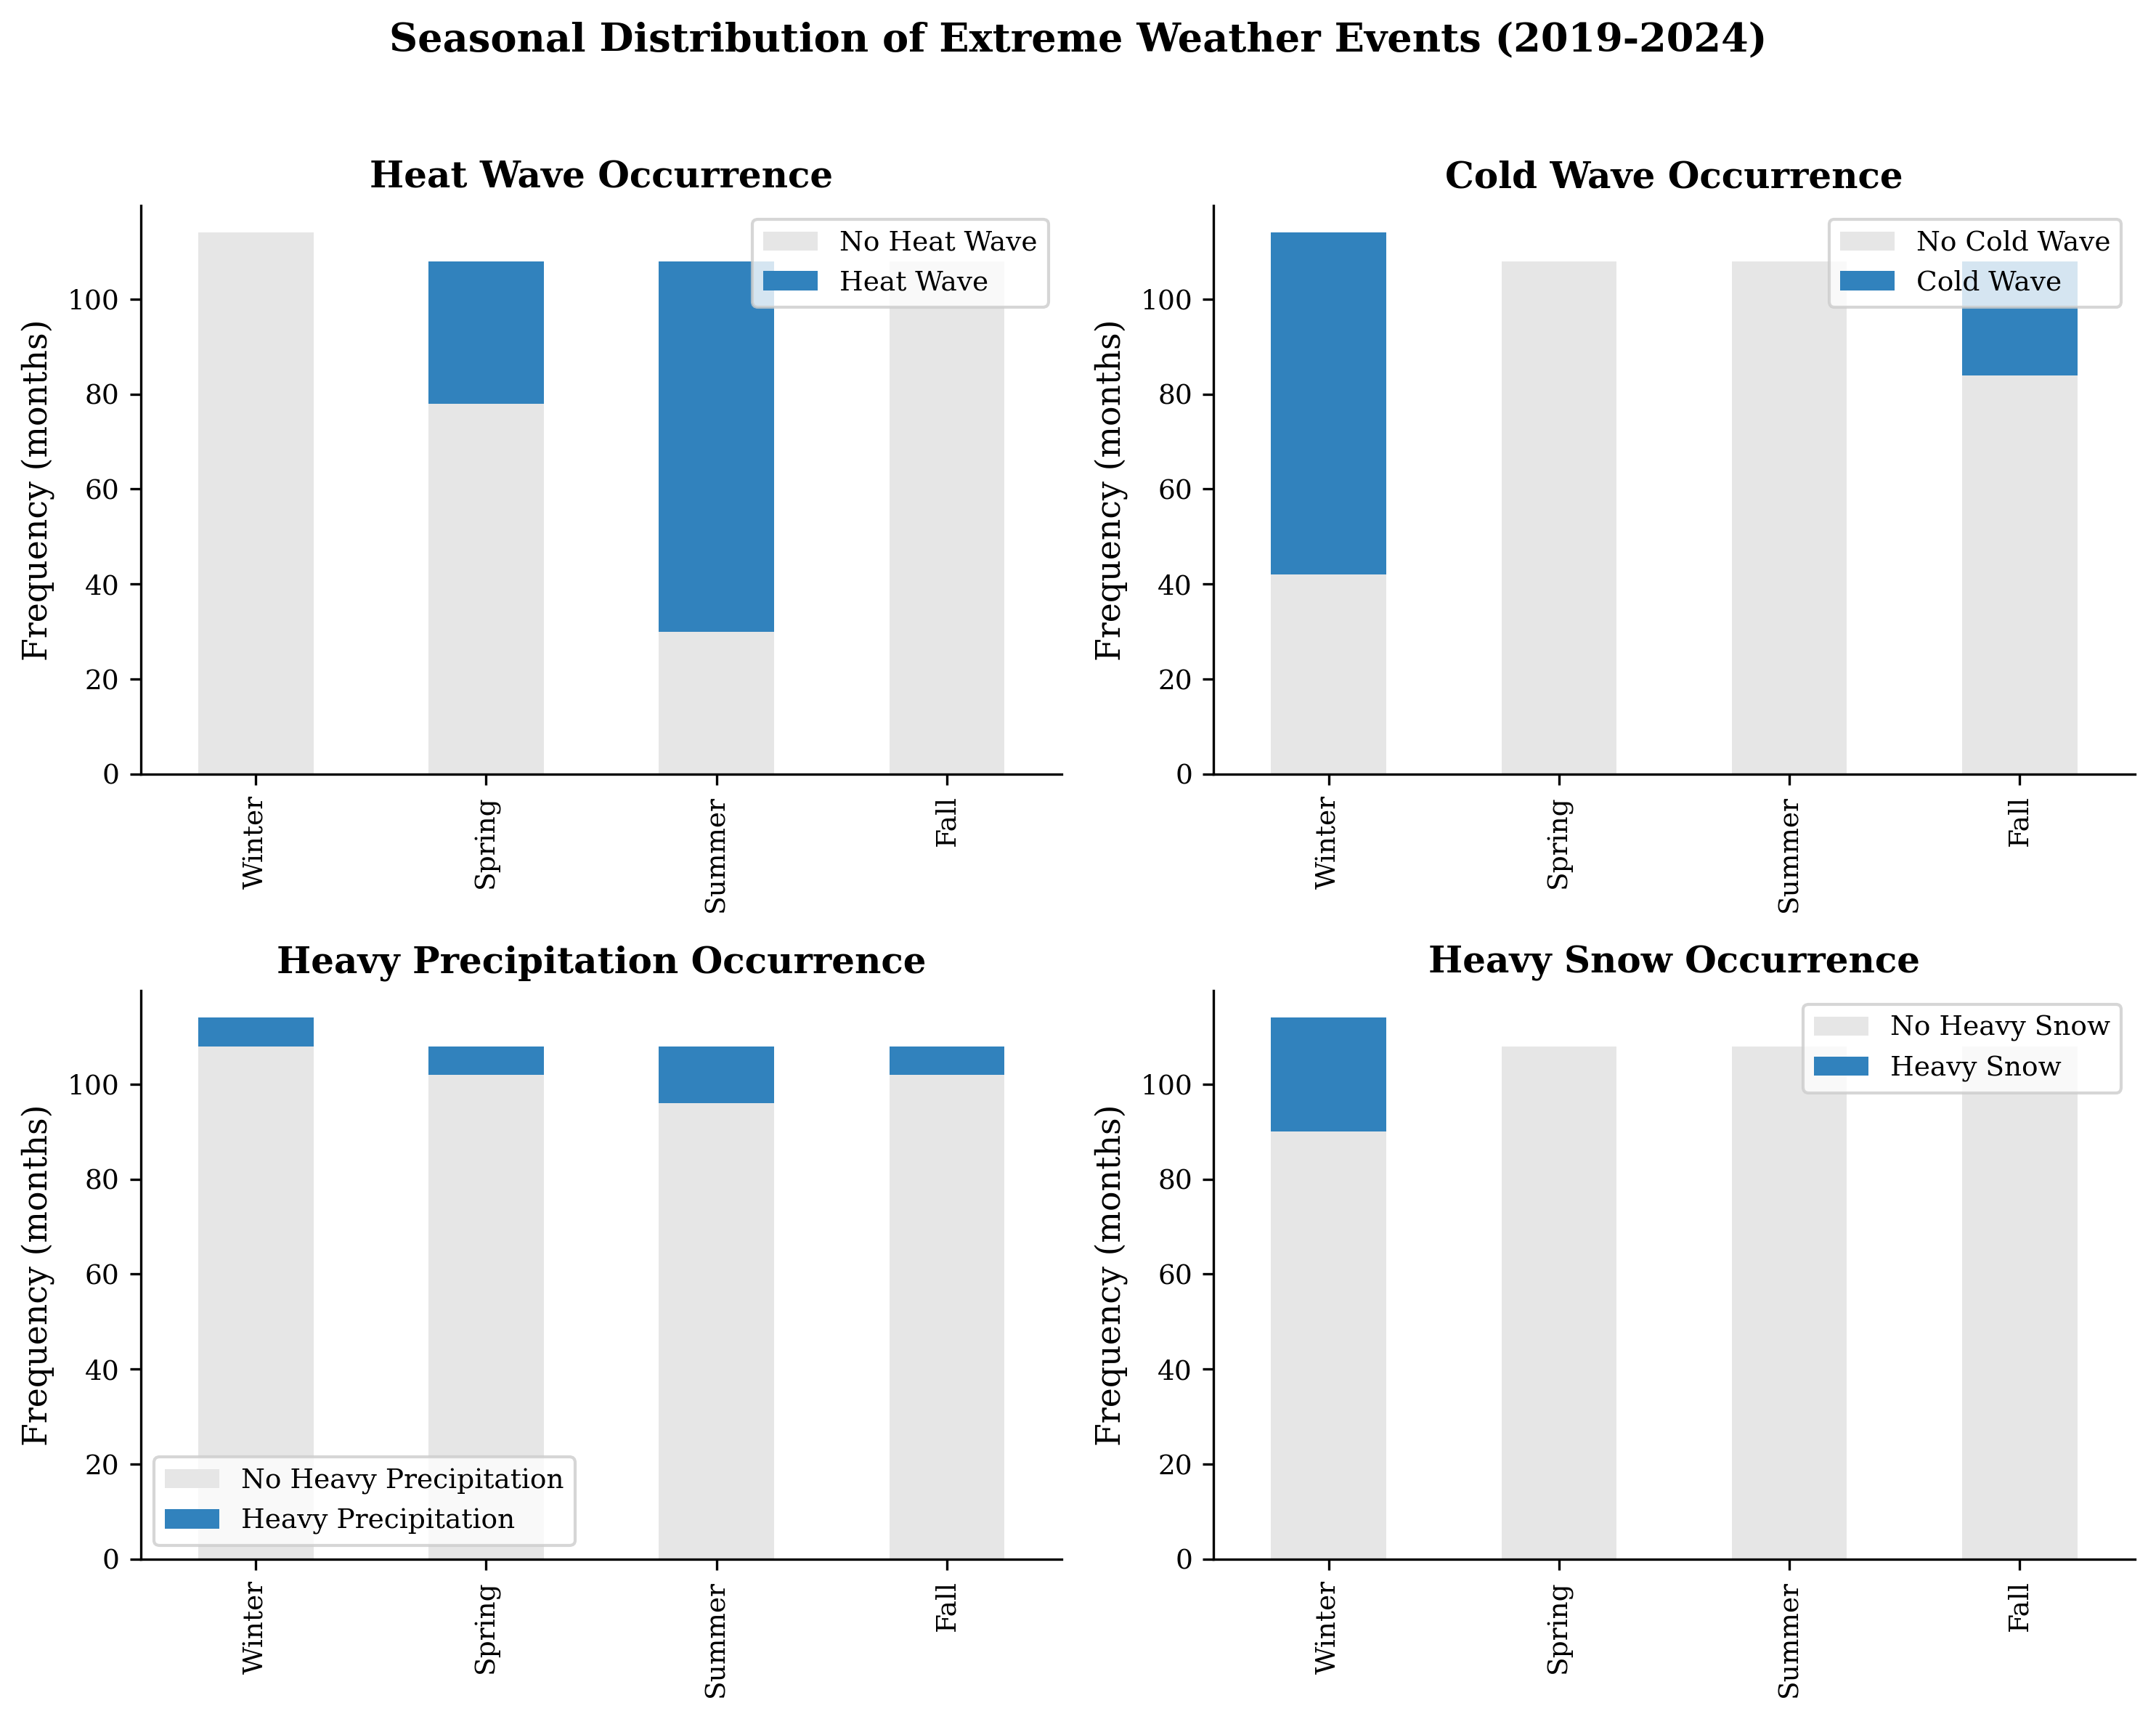

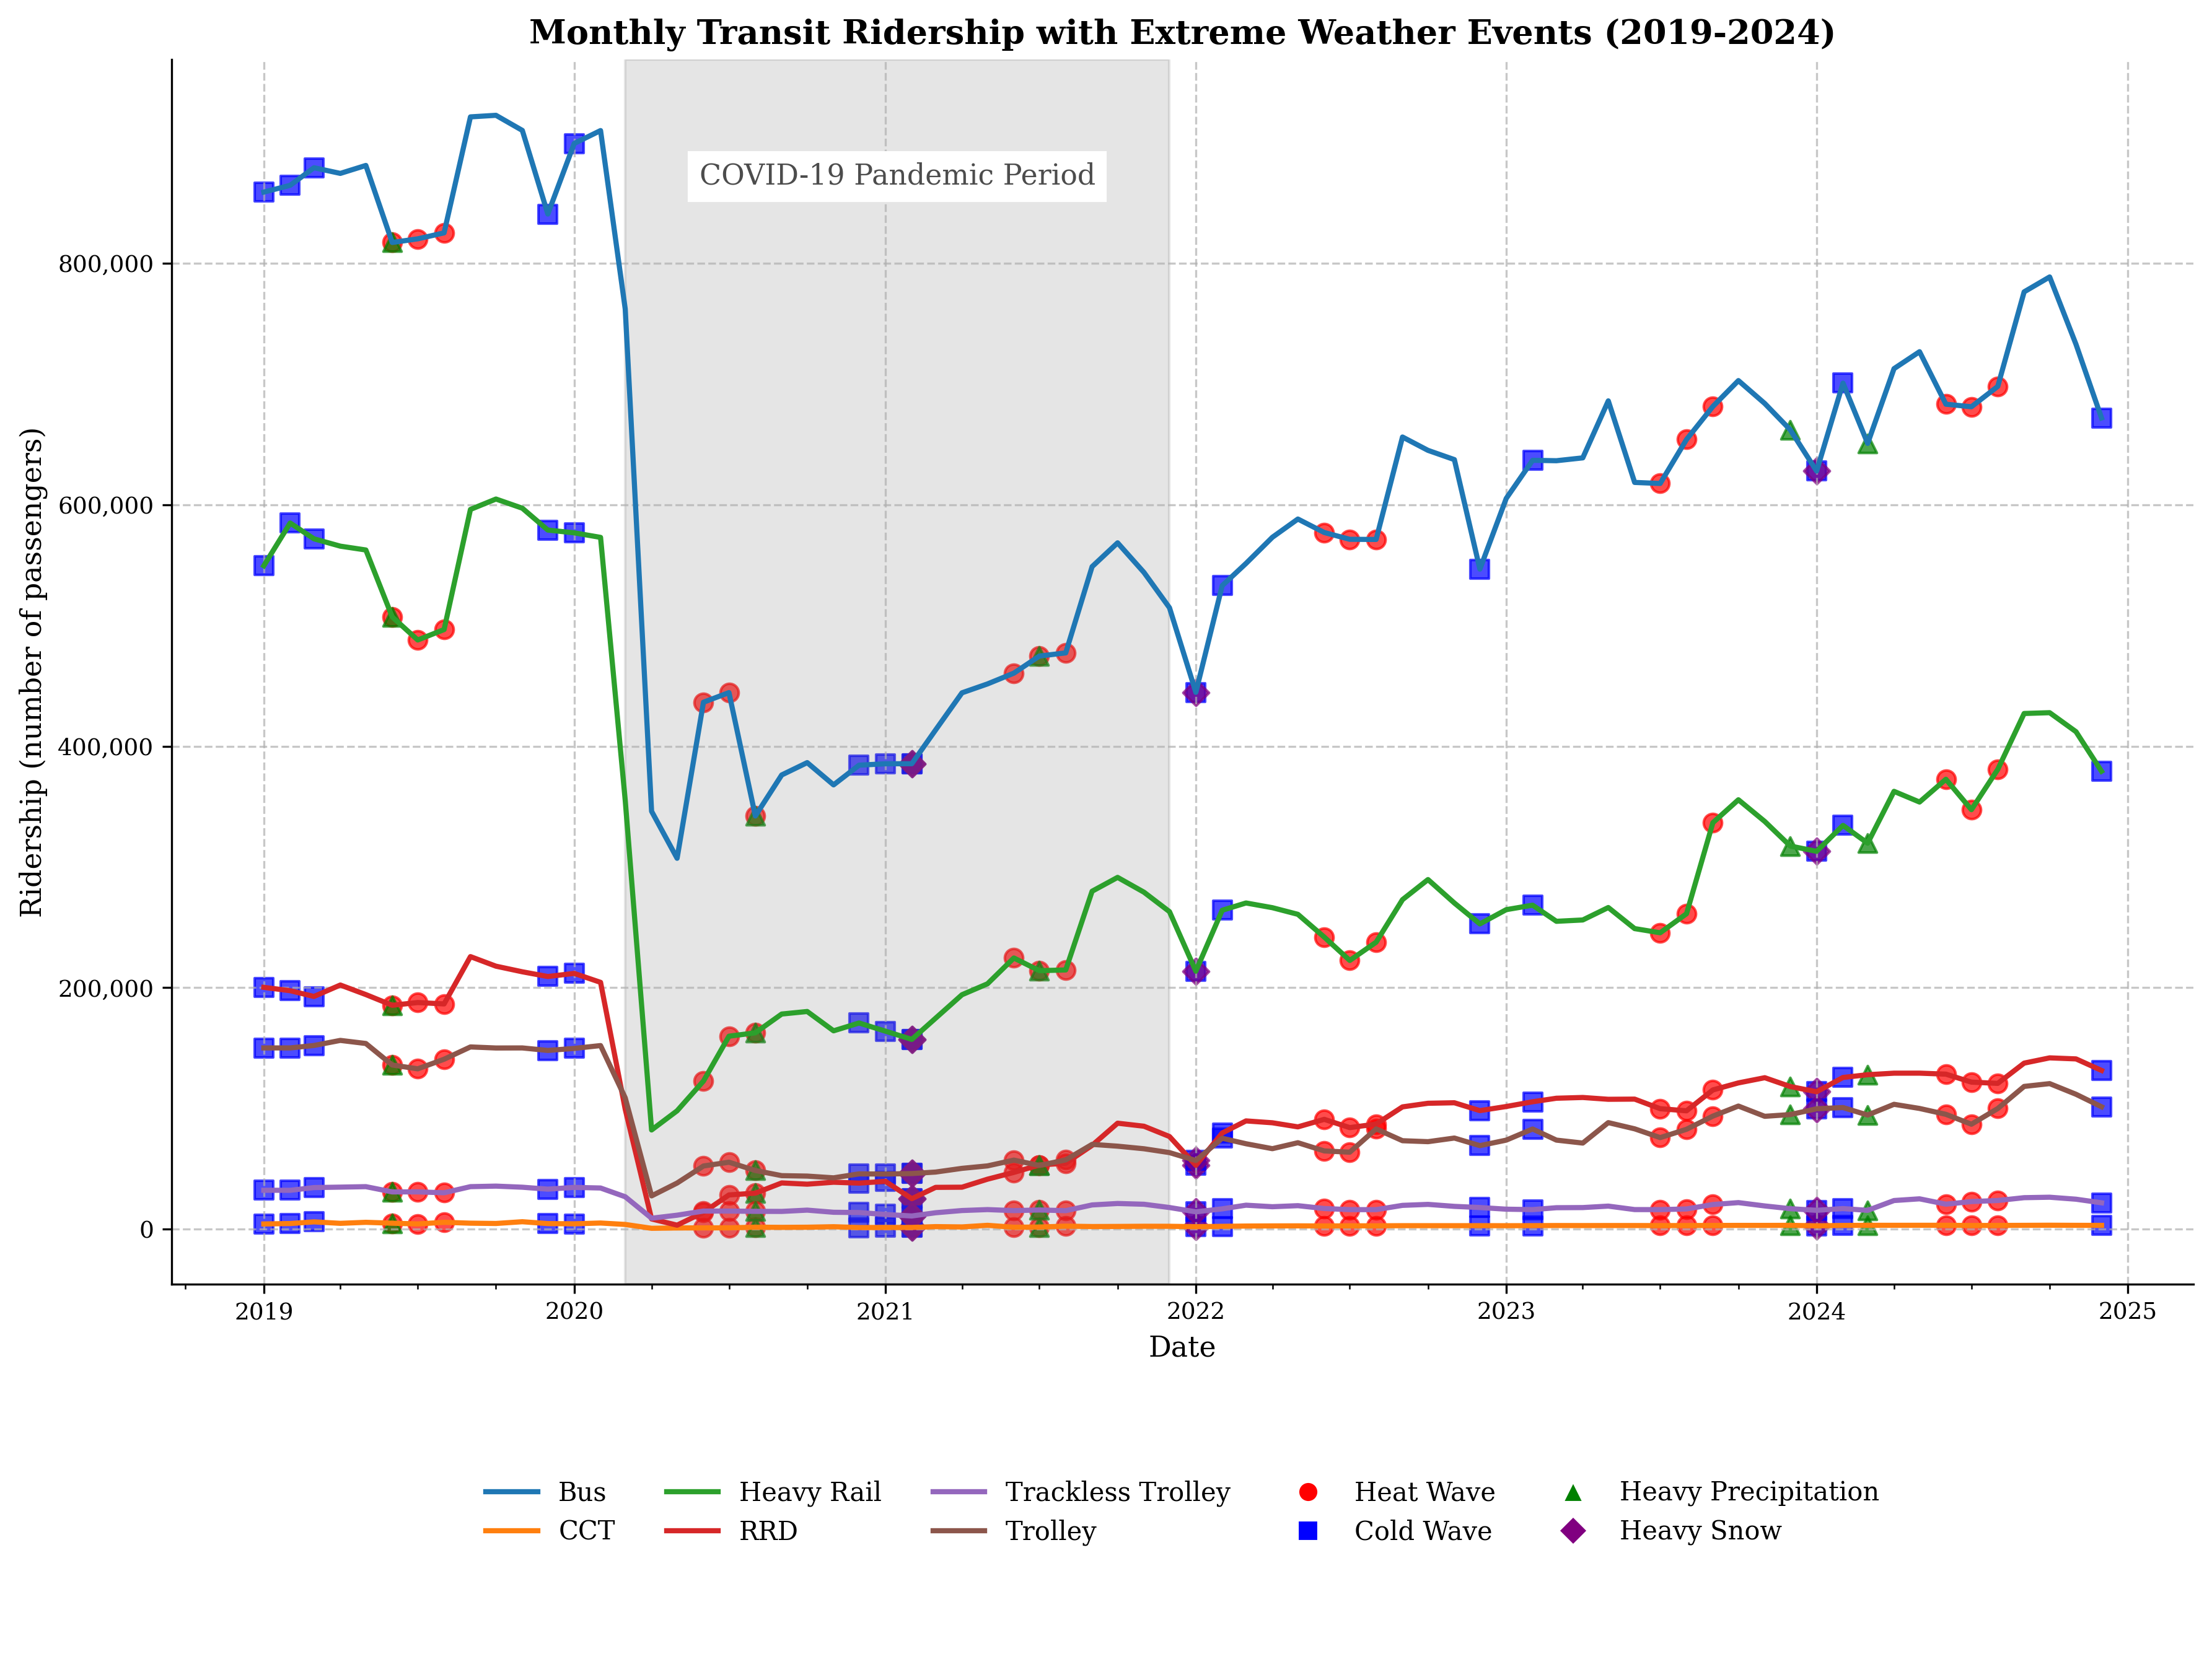

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm

# Find available serif fonts and set visualization styles
available_fonts = [f.name for f in fm.fontManager.ttflist]
available_serif_fonts = [f for f in available_fonts if 'serif' in f.lower()]
print("Available serif fonts:", available_serif_fonts)

# Set an available serif font (DejaVu Serif is commonly available)
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 13
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# Set custom color palette based on ColorBrewer - colorblind safe
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
sns.set_palette(colors)

# Define functions for data preprocessing
def load_and_preprocess_data(file_path):
    """
    Load transit ridership data and perform initial preprocessing.

    Parameters:
    ----------
    file_path : str
        Path to the CSV file containing the data.

    Returns:
    -------
    pandas.DataFrame
        Preprocessed dataframe with additional features.
    """
    # Load data
    df = pd.read_csv(file_path)

    # Examine data structure
    print("Data overview:")
    print(f"Shape: {df.shape}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())

    # Basic preprocessing
    # Convert Year and Month to datetime
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

    # Create season variable
    df['Season'] = pd.cut(
        df['Month'],
        bins=[0, 3, 6, 9, 12],
        labels=['Winter', 'Spring', 'Summer', 'Fall'],
        include_lowest=True
    )

    # Create variables for any extreme weather event
    df['Any_Heat_Wave'] = df['Heat_Wave_Days'] > 0
    df['Any_Cold_Wave'] = df['Cold_Wave_Days'] > 0
    df['Any_Heavy_Precip'] = df['Heavy_Precip_Days'] > 0
    df['Any_Heavy_Snow'] = df['Heavy_Snow_Days'] > 0
    df['Any_Extreme_Weather'] = (df['Any_Heat_Wave'] | df['Any_Cold_Wave'] |
                                df['Any_Heavy_Precip'] | df['Any_Heavy_Snow'])

    # Display summary statistics
    print("\nSummary statistics:")
    print(df.describe())

    # Check unique values of categorical variables
    print("\nUnique transit modes:")
    print(df['Mode'].unique())
    print("\nPandemic periods:")
    print(df['Pandemic_Period'].unique())

    return df

def create_seasonal_weather_plot(df):
    """
    Create enhanced visualization showing the frequency of extreme weather events by season.

    Parameters:
    ----------
    df : pandas.DataFrame
        Preprocessed dataframe with weather event indicators.

    Returns:
    -------
    fig : matplotlib.figure.Figure
        The created figure object.
    """
    # Set up figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Seasonal Distribution of Extreme Weather Events (2019-2024)', fontweight='bold')

    # Define a consistent color palette for True/False values
    palette = {"False": "#e6e6e6", "True": "#3182bd"}

    # Heat Waves
    ax1 = axes[0, 0]
    counts = df.groupby(['Season', 'Any_Heat_Wave'], observed=True).size().reset_index(name='count')
    pivot_table = counts.pivot(index='Season', columns='Any_Heat_Wave', values='count').fillna(0)
    pivot_table.plot(kind='bar', stacked=True, ax=ax1, color=[palette["False"], palette["True"]])
    ax1.set_title('Heat Wave Occurrence', fontweight='bold')
    ax1.set_ylabel('Frequency (months)')
    ax1.set_xlabel('')
    ax1.legend(['No Heat Wave', 'Heat Wave'])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Cold Waves
    ax2 = axes[0, 1]
    counts = df.groupby(['Season', 'Any_Cold_Wave'], observed=True).size().reset_index(name='count')
    pivot_table = counts.pivot(index='Season', columns='Any_Cold_Wave', values='count').fillna(0)
    pivot_table.plot(kind='bar', stacked=True, ax=ax2, color=[palette["False"], palette["True"]])
    ax2.set_title('Cold Wave Occurrence', fontweight='bold')
    ax2.set_ylabel('Frequency (months)')
    ax2.set_xlabel('')
    ax2.legend(['No Cold Wave', 'Cold Wave'])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Heavy Precipitation
    ax3 = axes[1, 0]
    counts = df.groupby(['Season', 'Any_Heavy_Precip'], observed=True).size().reset_index(name='count')
    pivot_table = counts.pivot(index='Season', columns='Any_Heavy_Precip', values='count').fillna(0)
    pivot_table.plot(kind='bar', stacked=True, ax=ax3, color=[palette["False"], palette["True"]])
    ax3.set_title('Heavy Precipitation Occurrence', fontweight='bold')
    ax3.set_ylabel('Frequency (months)')
    ax3.set_xlabel('')
    ax3.legend(['No Heavy Precipitation', 'Heavy Precipitation'])
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)

    # Heavy Snow
    ax4 = axes[1, 1]
    counts = df.groupby(['Season', 'Any_Heavy_Snow'], observed=True).size().reset_index(name='count')
    pivot_table = counts.pivot(index='Season', columns='Any_Heavy_Snow', values='count').fillna(0)
    pivot_table.plot(kind='bar', stacked=True, ax=ax4, color=[palette["False"], palette["True"]])
    ax4.set_title('Heavy Snow Occurrence', fontweight='bold')
    ax4.set_ylabel('Frequency (months)')
    ax4.set_xlabel('')
    ax4.legend(['No Heavy Snow', 'Heavy Snow'])
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('fig1_seasonal_weather_distribution.png')

    return fig

def create_ridership_time_series(df):
    """
    Create enhanced time series visualization of ridership by transit mode with weather markers.

    Parameters:
    ----------
    df : pandas.DataFrame
        Preprocessed dataframe with transit ridership and weather indicators.

    Returns:
    -------
    fig : matplotlib.figure.Figure
        The created figure object.
    """
    fig = plt.figure(figsize=(12, 9))

    # Create GridSpec for main plot and legend
    gs = GridSpec(2, 1, height_ratios=[5, 1])
    ax_main = fig.add_subplot(gs[0])
    ax_legend = fig.add_subplot(gs[1])

    # Get unique modes
    modes = df['Mode'].unique()
    colors = sns.color_palette(n_colors=len(modes))
    mode_color_map = dict(zip(modes, colors))

    # Create custom legend for weather events
    ax_legend.axis('off')

    # Label columns for the legend
    legend_elements = []
    for mode in modes:
        legend_elements.append(plt.Line2D([0], [0], color=mode_color_map[mode], lw=2, label=f"{mode}"))

    # Add weather event indicators to legend
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                         markerfacecolor='red', markersize=8, label='Heat Wave'))
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w',
                         markerfacecolor='blue', markersize=8, label='Cold Wave'))
    legend_elements.append(plt.Line2D([0], [0], marker='^', color='w',
                         markerfacecolor='green', markersize=8, label='Heavy Precipitation'))
    legend_elements.append(plt.Line2D([0], [0], marker='D', color='w',
                         markerfacecolor='purple', markersize=8, label='Heavy Snow'))

    # Create the legend
    ax_legend.legend(handles=legend_elements, loc='center', ncol=5, frameon=False, fontsize=10)

    for mode in modes:
        mode_data = df[df['Mode'] == mode].copy()

        # Sort by date
        mode_data = mode_data.sort_values('Date')

        # Plot the ridership
        ax_main.plot(mode_data['Date'], mode_data['Ridership'],
                label=mode, color=mode_color_map[mode], linewidth=2)

        # Mark extreme weather events with distinct markers
        heat_events = mode_data[mode_data['Any_Heat_Wave']]
        cold_events = mode_data[mode_data['Any_Cold_Wave']]
        precip_events = mode_data[mode_data['Any_Heavy_Precip']]
        snow_events = mode_data[mode_data['Any_Heavy_Snow']]

        if len(heat_events) > 0:
            ax_main.scatter(heat_events['Date'], heat_events['Ridership'],
                       marker='o', s=50, color='red', alpha=0.7)
        if len(cold_events) > 0:
            ax_main.scatter(cold_events['Date'], cold_events['Ridership'],
                       marker='s', s=50, color='blue', alpha=0.7)
        if len(precip_events) > 0:
            ax_main.scatter(precip_events['Date'], precip_events['Ridership'],
                       marker='^', s=50, color='green', alpha=0.7)
        if len(snow_events) > 0:
            ax_main.scatter(snow_events['Date'], snow_events['Ridership'],
                       marker='D', s=50, color='purple', alpha=0.7)

    # Add pandemic period shading
    pandemic_start = df[df['Pandemic_Period'] == 'Pandemic']['Date'].min()
    pandemic_end = df[df['Pandemic_Period'] == 'Pandemic']['Date'].max()
    ax_main.axvspan(pandemic_start, pandemic_end, color='gray', alpha=0.2)

    # Add text label for pandemic period
    mid_pandemic = pandemic_start + (pandemic_end - pandemic_start) / 2
    ax_main.text(mid_pandemic, ax_main.get_ylim()[1] * 0.9, 'COVID-19 Pandemic Period',
             ha='center', va='center', fontsize=11, backgroundcolor='white', alpha=0.7)

    # Format x-axis with years
    ax_main.xaxis.set_major_locator(mdates.YearLocator())
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax_main.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4, 7, 10]))

    # Format y-axis with thousands separator
    ax_main.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    ax_main.set_title('Monthly Transit Ridership with Extreme Weather Events (2019-2024)',
                  fontsize=13, fontweight='bold')
    ax_main.set_xlabel('Date', fontsize=11)
    ax_main.set_ylabel('Ridership (number of passengers)', fontsize=11)
    ax_main.grid(True, linestyle='--', alpha=0.7)
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('fig2_ridership_time_series.png')

    return fig

# Load data
df = load_and_preprocess_data('monthly_mode_ridership_with_pandemic_period_label.csv')

# Generate enhanced plots
seasonal_weather_fig = create_seasonal_weather_plot(df)
ridership_time_series_fig = create_ridership_time_series(df)
plt.show()


Weather Impact Analysis Results:
  Weather_Event  Percent_Change  P_Value
0     Heat Wave         -7.3046   0.0433
1     Cold Wave          6.1984   0.1861
2  Heavy Precip          2.2326   0.7212
3    Heavy Snow        -31.6481   0.0000

Comprehensive Model Results:
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.6075      0.030     54.462      0.000       1.549       1.666
Any_Heat_Wave[T.True]           -0.0893      0.023     -3.903      0.000      -0.134      -0.044
Any_Cold_Wave[T.True]           -0.0464      0.022     -2.080      0.038      -0.090      -0.002
Any_Heavy_Precip[T.True]        -0.0595      0.031     -1.949      0.052      -0.120       0.001
Any_Heavy_Snow[T.True]          -0.1316      0.039     -3.413      0.001      -0.208      -0.056
C(Mode)[T.CCT]                   0.0440      0.023  

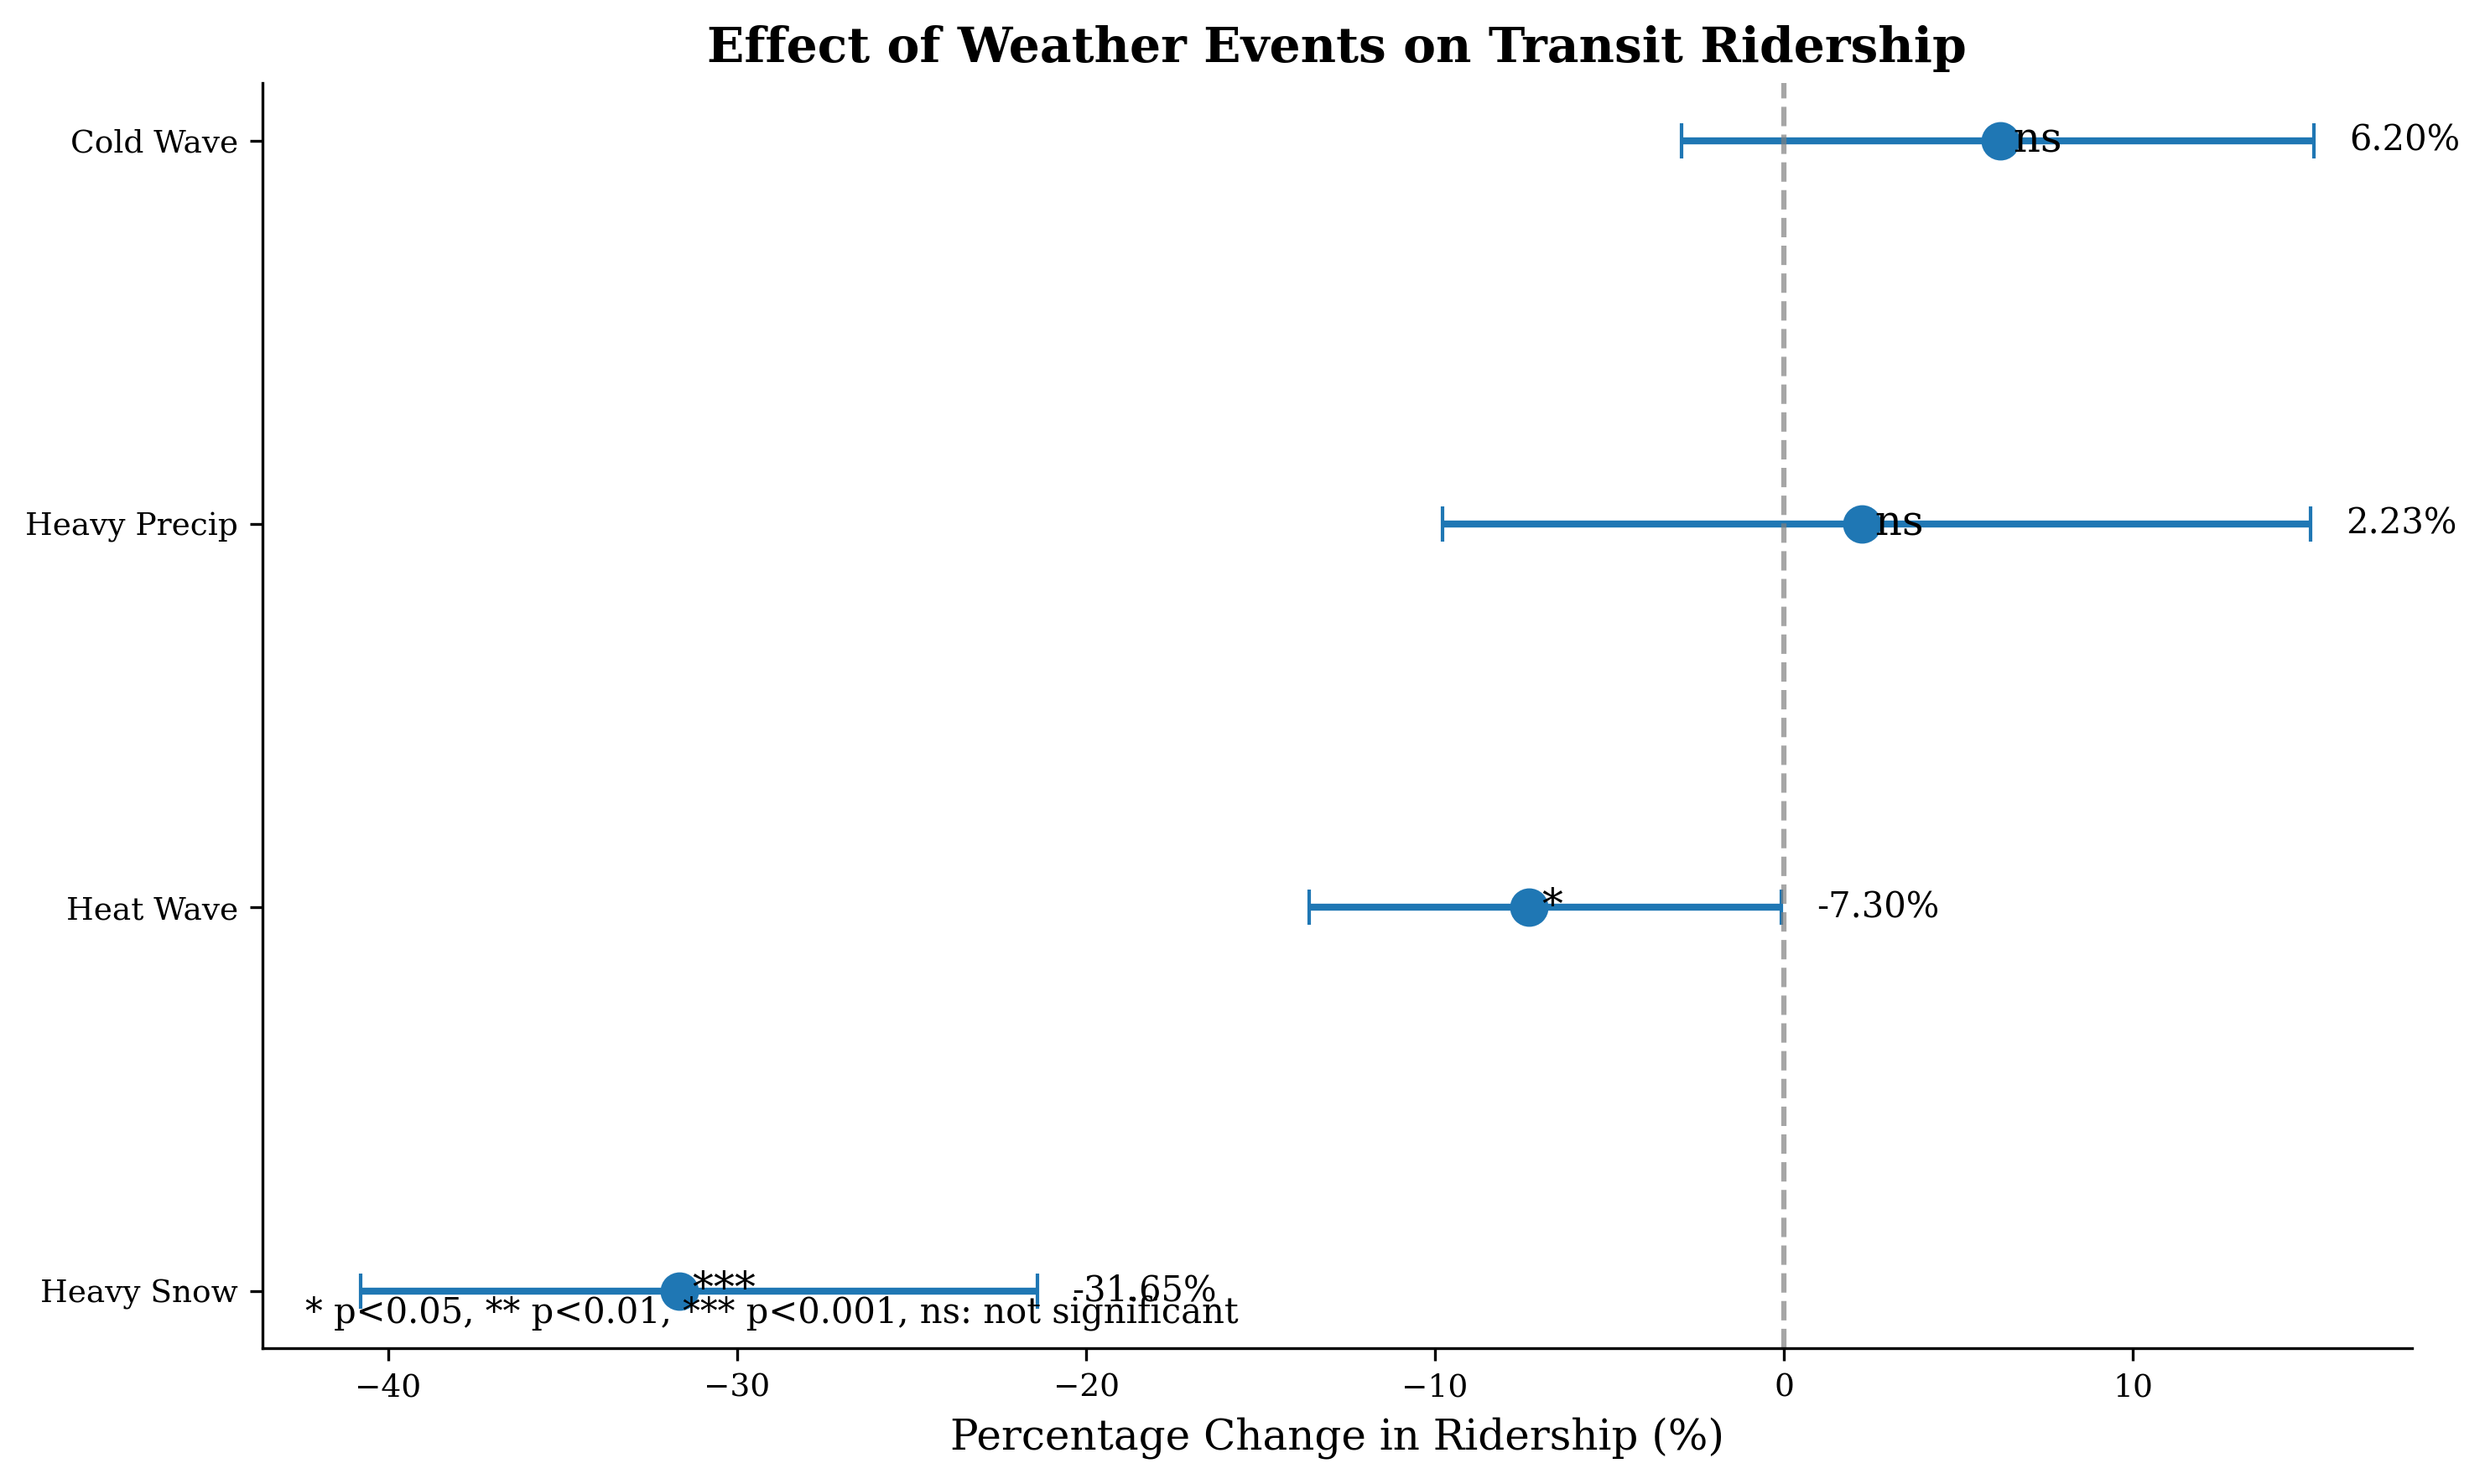

In [2]:
def normalize_ridership(df):
    """
    Normalize ridership for each mode to make comparison easier.

    Parameters:
    ----------
    df : pandas.DataFrame
        Dataframe with ridership data.

    Returns:
    -------
    pandas.DataFrame
        Dataframe with added normalized ridership column.
    """
    # Create a pivot to get average ridership by mode during non-extreme weather periods
    baseline = df[~df['Any_Extreme_Weather']].groupby('Mode')['Ridership'].mean().reset_index()
    baseline.columns = ['Mode', 'Baseline_Ridership']

    # Merge back to main dataframe
    df = pd.merge(df, baseline, on='Mode')

    # Calculate normalized ridership
    df['Normalized_Ridership'] = df['Ridership'] / df['Baseline_Ridership']

    return df

def analyze_weather_impact(df, weather_type):
    """
    Run regression analysis for specific weather event type.

    Parameters:
    ----------
    df : pandas.DataFrame
        Preprocessed dataframe with normalized ridership data.
    weather_type : str
        The type of weather event to analyze (e.g., 'Heat_Wave').

    Returns:
    -------
    statsmodels.regression.linear_model.RegressionResultsWrapper
        The regression model results.
    """
    # Filter data to exclude pandemic period for cleaner analysis of weather effects
    non_pandemic_data = df[df['Pandemic_Period'] != 'Pandemic'].copy()

    # Define formula with fixed effects for mode, season, and year
    formula = f"Normalized_Ridership ~ Any_{weather_type} + C(Mode) + C(Season) + C(Year)"

    # Run regression
    model = ols(formula, data=non_pandemic_data).fit()
    model = sm.stats.anova_lm(model, typ=2)  # Type II ANOVA for unbalanced design

    return model

def create_weather_impact_table(df):
    """
    Create a formatted table of weather impacts on ridership.

    Parameters:
    ----------
    df : pandas.DataFrame
        Dataframe with normalized ridership data.

    Returns:
    -------
    pandas.DataFrame
        Summary table of weather impacts.
    """
    # Weather event types to analyze
    weather_types = ['Heat_Wave', 'Cold_Wave', 'Heavy_Precip', 'Heavy_Snow']

    results = []

    # Filter data to exclude pandemic period
    non_pandemic_df = df[df['Pandemic_Period'] != 'Pandemic'].copy()

    for weather in weather_types:
        # Compare means
        with_event = non_pandemic_df[non_pandemic_df[f'Any_{weather}'] == True]['Normalized_Ridership']
        without_event = non_pandemic_df[non_pandemic_df[f'Any_{weather}'] == False]['Normalized_Ridership']

        mean_with = with_event.mean()
        mean_without = without_event.mean()
        pct_change = ((mean_with - mean_without) / mean_without) * 100

        # Calculate 95% confidence intervals using bootstrap
        n_bootstrap = 1000
        pct_changes = []

        for _ in range(n_bootstrap):
            sample_with = with_event.sample(frac=1, replace=True).mean()
            sample_without = without_event.sample(frac=1, replace=True).mean()
            pct_changes.append(((sample_with - sample_without) / sample_without) * 100)

        ci_lower = np.percentile(pct_changes, 2.5)
        ci_upper = np.percentile(pct_changes, 97.5)

        # T-test
        t_stat, p_val = stats.ttest_ind(with_event, without_event, equal_var=False)

        # Create a summary row
        results.append({
            'Weather_Event': weather.replace('_', ' '),
            'Mean_Ridership_With_Event': mean_with,
            'Mean_Ridership_Without_Event': mean_without,
            'Percent_Change': pct_change,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'T_Statistic': t_stat,
            'P_Value': p_val,
            'Sample_Size_With_Event': len(with_event),
            'Sample_Size_Without_Event': len(without_event)
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

def create_comprehensive_model(df):
    """
    Run comprehensive model with all weather variables together.

    Parameters:
    ----------
    df : pandas.DataFrame
        Dataframe with normalized ridership data.

    Returns:
    -------
    statsmodels.regression.linear_model.RegressionResultsWrapper
        The comprehensive regression model results.
    """
    formula = """Normalized_Ridership ~ Any_Heat_Wave + Any_Cold_Wave +
                 Any_Heavy_Precip + Any_Heavy_Snow +
                 C(Mode) + C(Season) + C(Year)"""

    comprehensive_model = ols(formula, data=df[df['Pandemic_Period'] != 'Pandemic']).fit()

    return comprehensive_model

def create_forest_plot(results_df):
    """
    Create a forest plot showing effect sizes with confidence intervals.

    Parameters:
    ----------
    results_df : pandas.DataFrame
        DataFrame containing results with confidence intervals.

    Returns:
    -------
    matplotlib.figure.Figure
        The forest plot figure.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Sort by effect size
    results_df = results_df.sort_values('Percent_Change')

    # Plot
    y_pos = range(len(results_df))
    ax.errorbar(
        results_df['Percent_Change'],
        y_pos,
        xerr=np.vstack([
            results_df['Percent_Change'] - results_df['CI_Lower'],
            results_df['CI_Upper'] - results_df['Percent_Change']
        ]),
        fmt='o',
        capsize=5,
        elinewidth=2,
        markersize=10
    )

    # Add vertical line at zero
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

    # Add labels and annotations
    for i, row in enumerate(results_df.itertuples()):
        # Add significance marker
        if row.P_Value < 0.001:
            significance = "***"
        elif row.P_Value < 0.01:
            significance = "**"
        elif row.P_Value < 0.05:
            significance = "*"
        else:
            significance = "ns"

        ax.text(row.Percent_Change, i, f" {significance}", va='center', fontsize=12)

        # Add effect size value
        ax.text(row.CI_Upper + 1, i, f"{row.Percent_Change:.2f}%", va='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(results_df['Weather_Event'])
    ax.set_xlabel('Percentage Change in Ridership (%)', fontsize=12)
    ax.set_title('Effect of Weather Events on Transit Ridership', fontsize=14, fontweight='bold')

    # Add significance legend
    ax.text(0.02, 0.02, "* p<0.05, ** p<0.01, *** p<0.001, ns: not significant",
        transform=ax.transAxes, fontsize=10)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('fig3_forest_plot_weather_effects.png')

    return fig

# Normalize ridership data
df = normalize_ridership(df)

# Generate weather impact table
weather_impact_table = create_weather_impact_table(df)
print("\nWeather Impact Analysis Results:")
print(weather_impact_table[['Weather_Event', 'Percent_Change', 'P_Value']].round(4))

# Create comprehensive model
comprehensive_model = create_comprehensive_model(df)
print("\nComprehensive Model Results:")
print(comprehensive_model.summary().tables[1])

# Create forest plot
forest_plot = create_forest_plot(weather_impact_table)
plt.show()


--- Bus ---

--- CCT ---

--- Heavy Rail ---

--- RRD ---

--- Trackless Trolley ---

--- Trolley ---


<ipython-input-3-0bd9d799067e>:110: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = pivot_data.applymap('{:.2f}%'.format) + sig_markers


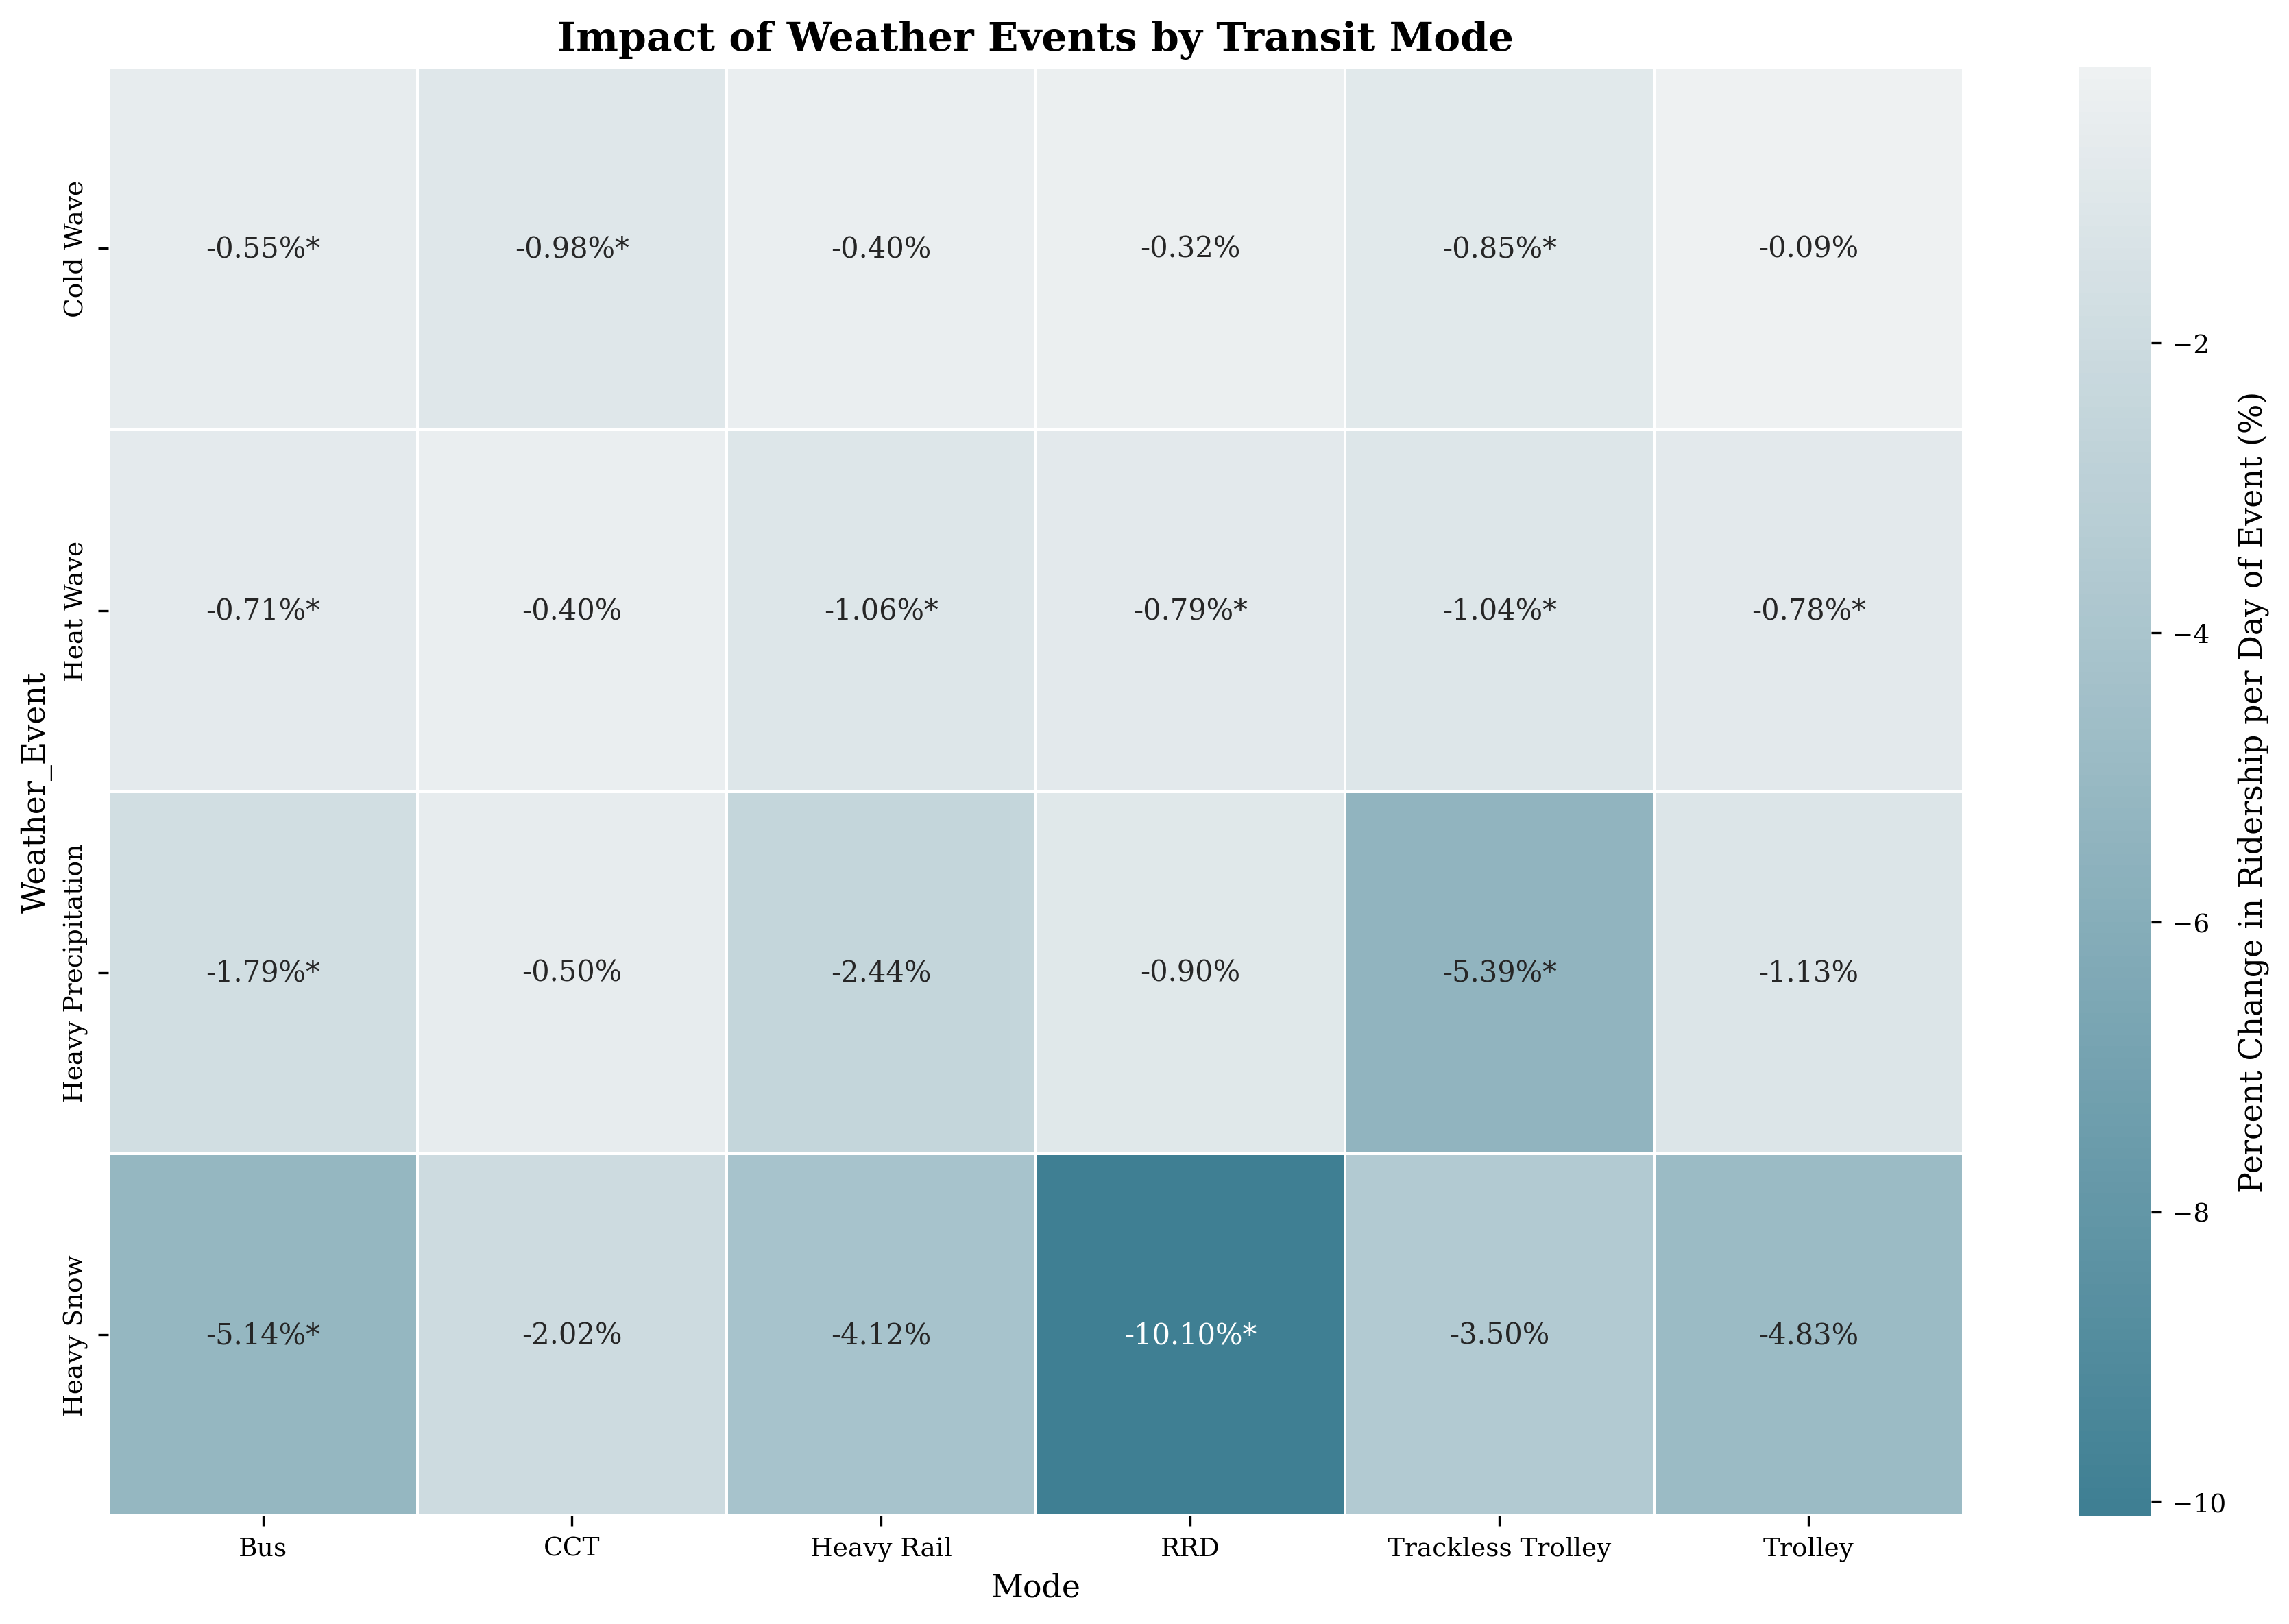

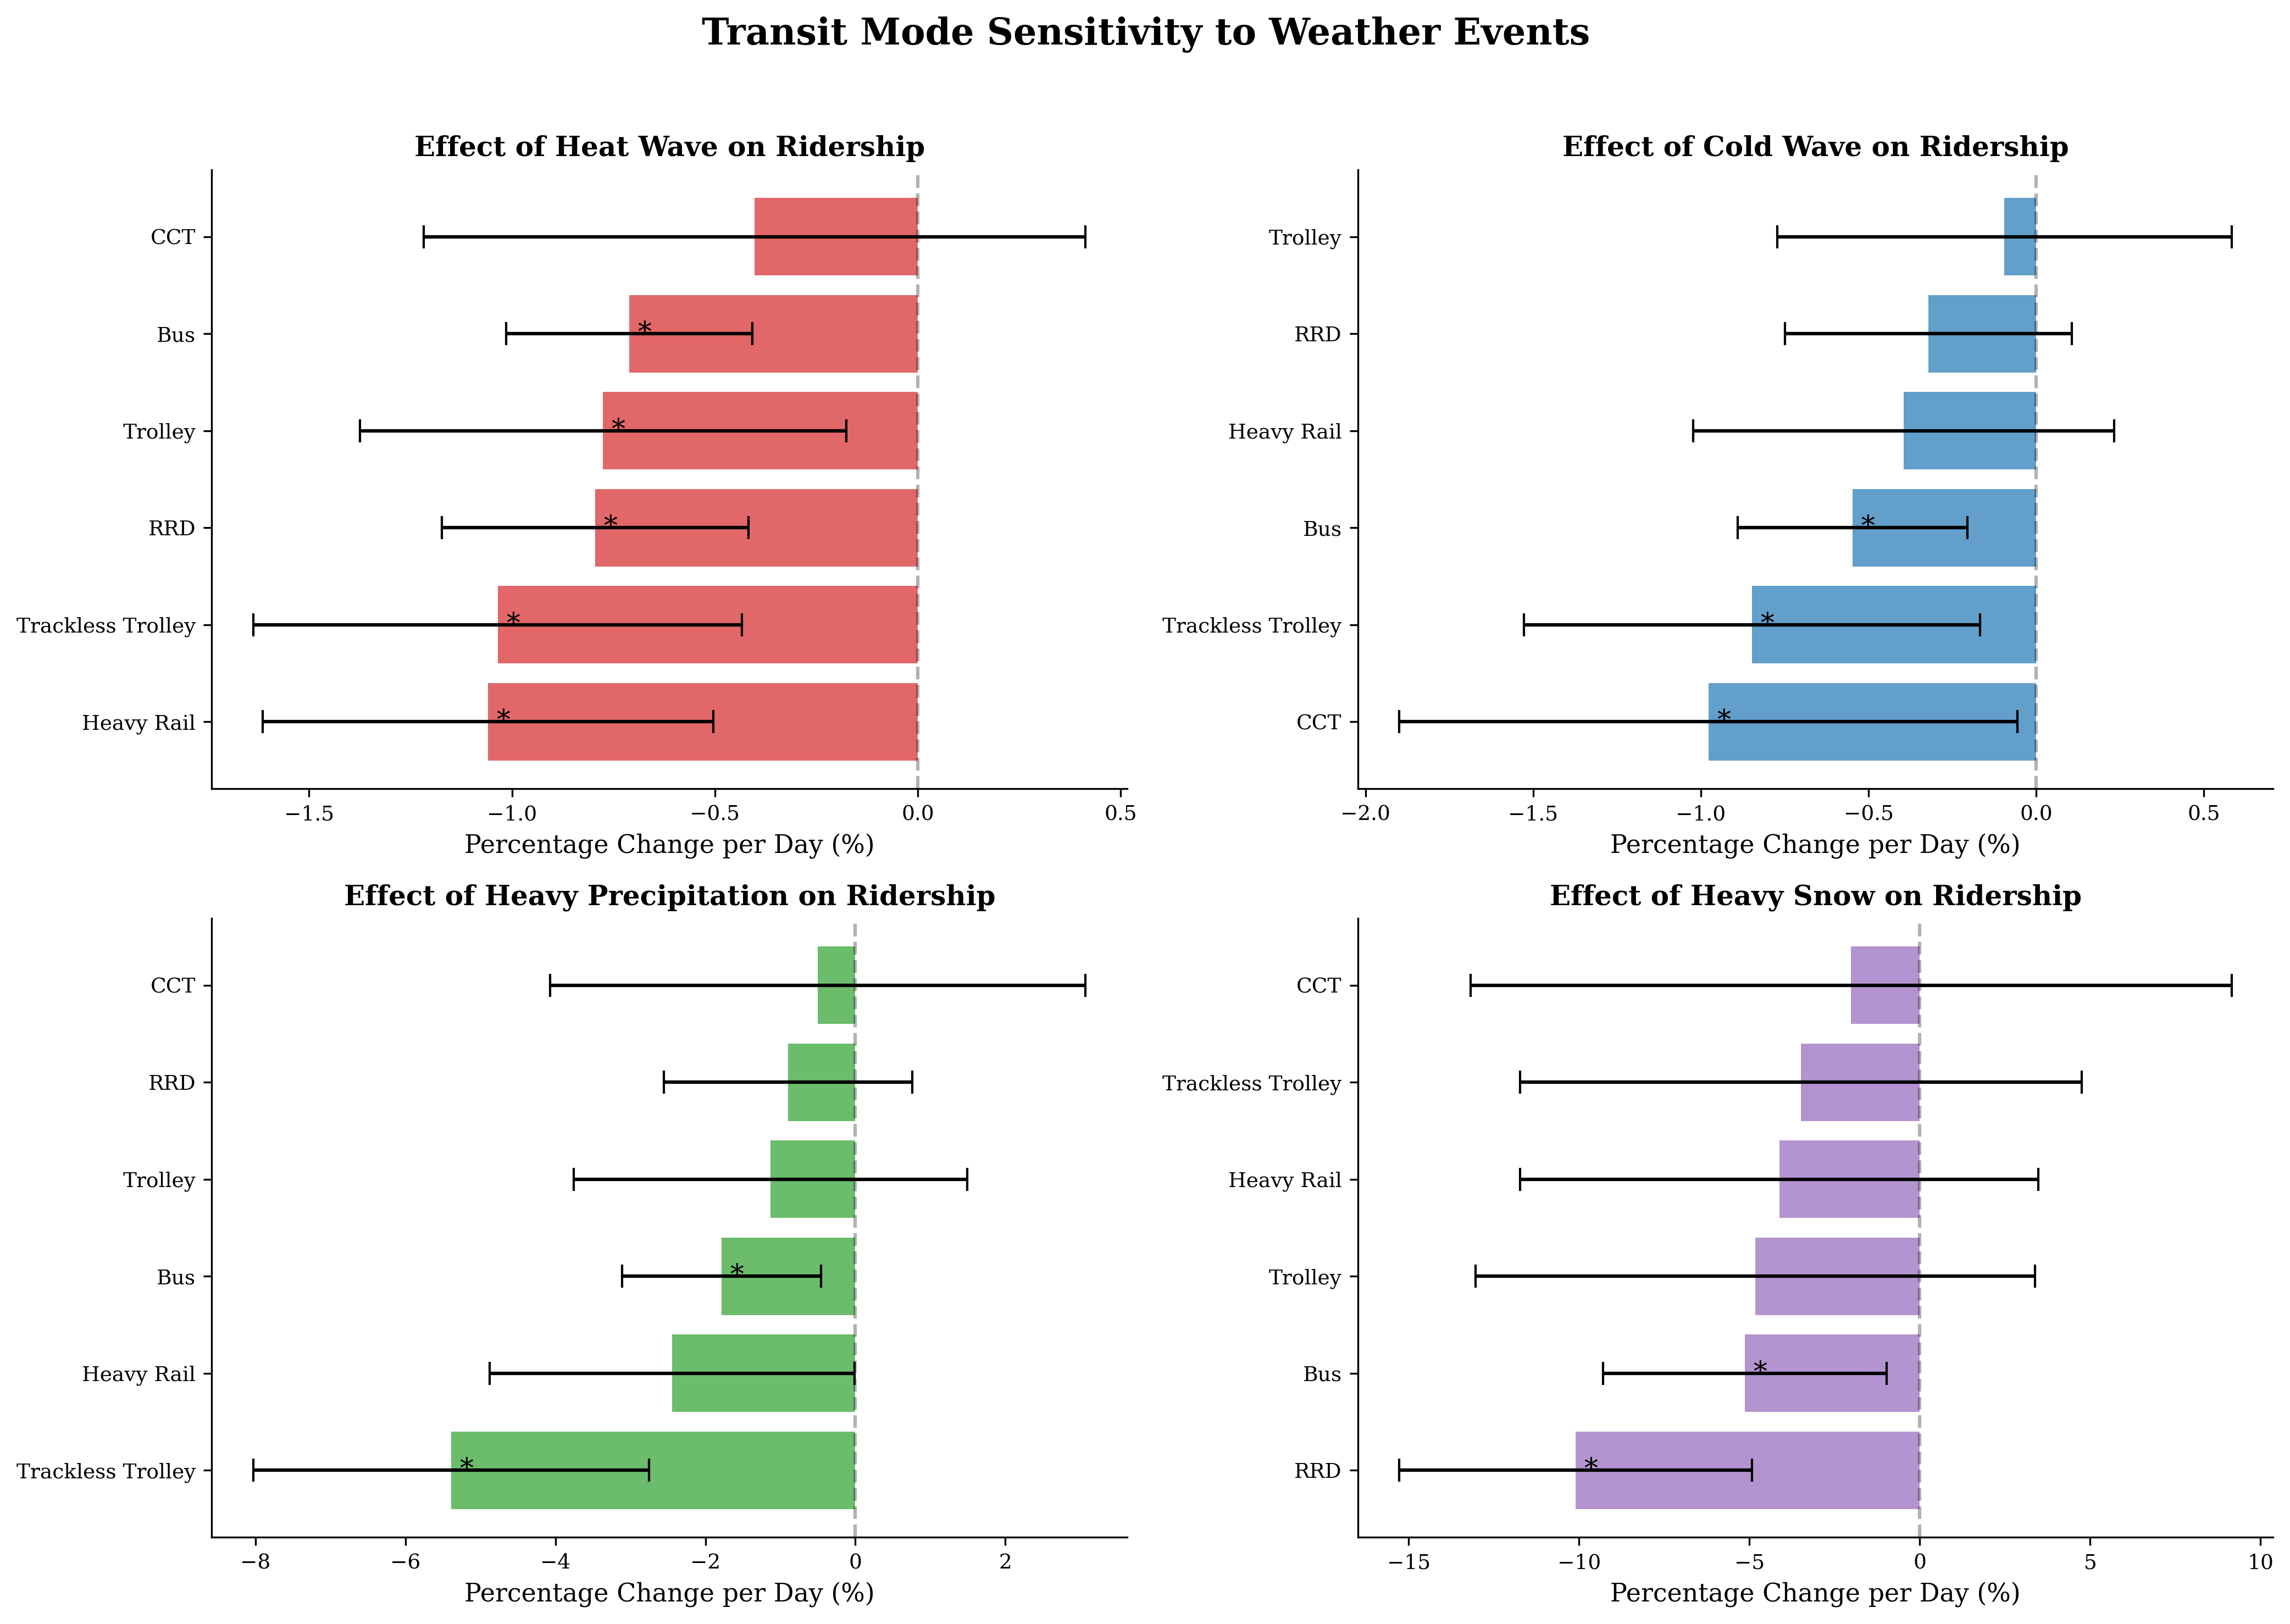

In [3]:
def analyze_mode_specific_impacts(df):
    """
    Analyze weather impacts for each transit mode separately.

    Parameters:
    ----------
    df : pandas.DataFrame
        Dataframe with ridership data.

    Returns:
    -------
    dict
        Dictionary containing mode-specific regression models.
    """
    # Prepare data structure for results
    mode_results = {}
    mode_summary = []

    for mode in df['Mode'].unique():
        mode_data = df[df['Mode'] == mode].copy()

        # Skip if not enough data
        if len(mode_data) < 30:
            print(f"Insufficient data for {mode}")
            continue

        print(f"\n--- {mode} ---")

        # Define formula for this mode
        formula = """Ridership ~ Heat_Wave_Days + Cold_Wave_Days +
                     Heavy_Precip_Days + Heavy_Snow_Days +
                     C(Season) + C(Year)"""

        # Run regression
        try:
            mode_model = ols(formula, data=mode_data[mode_data['Pandemic_Period'] != 'Pandemic']).fit()
            mode_results[mode] = mode_model

            # Create simplified output table
            coefs = mode_model.params[['Heat_Wave_Days', 'Cold_Wave_Days',
                                       'Heavy_Precip_Days', 'Heavy_Snow_Days']]
            pvals = mode_model.pvalues[['Heat_Wave_Days', 'Cold_Wave_Days',
                                        'Heavy_Precip_Days', 'Heavy_Snow_Days']]

            # Calculate standard errors for plotting
            std_errs = mode_model.bse[['Heat_Wave_Days', 'Cold_Wave_Days',
                                      'Heavy_Precip_Days', 'Heavy_Snow_Days']]

            # Calculate confidence intervals
            ci_lower = coefs - 1.96 * std_errs
            ci_upper = coefs + 1.96 * std_errs

            # Calculate percentage effect based on average ridership for this mode
            avg_ridership = mode_data[mode_data['Pandemic_Period'] != 'Pandemic']['Ridership'].mean()
            pct_effects = (coefs / avg_ridership) * 100
            pct_effects_ci_lower = (ci_lower / avg_ridership) * 100
            pct_effects_ci_upper = (ci_upper / avg_ridership) * 100

            # Store results for summary table
            for weather, coef, p_val, pct, pct_lower, pct_upper in zip(
                ['Heat Wave', 'Cold Wave', 'Heavy Precipitation', 'Heavy Snow'],
                coefs, pvals, pct_effects, pct_effects_ci_lower, pct_effects_ci_upper
            ):
                mode_summary.append({
                    'Mode': mode,
                    'Weather_Event': weather,
                    'Coefficient': coef,
                    'P_Value': p_val,
                    'Pct_Effect_Per_Day': pct,
                    'Pct_Effect_CI_Lower': pct_lower,
                    'Pct_Effect_CI_Upper': pct_upper
                })

        except Exception as e:
            print(f"Error running regression for {mode}: {e}")

    mode_summary_df = pd.DataFrame(mode_summary)
    return mode_results, mode_summary_df

def create_mode_specific_heatmap(mode_summary_df):
    """
    Create a heatmap showing weather impacts across different transit modes.

    Parameters:
    ----------
    mode_summary_df : pandas.DataFrame
        DataFrame with mode-specific impact results.

    Returns:
    -------
    matplotlib.figure.Figure
        The heatmap figure.
    """
    # Pivot the data for heatmap
    pivot_data = mode_summary_df.pivot_table(
        index='Weather_Event',
        columns='Mode',
        values='Pct_Effect_Per_Day'
    )

    # Create significance markers
    sig_markers = mode_summary_df.pivot_table(
        index='Weather_Event',
        columns='Mode',
        values='P_Value',
        aggfunc=lambda x: '*' if x.iloc[0] < 0.05 else ''
    )

    # Create annotations with significance markers
    annotations = pivot_data.applymap('{:.2f}%'.format) + sig_markers

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(12, 8))

    # Custom diverging colormap centered at zero
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(
        pivot_data,
        annot=annotations,
        fmt='',
        cmap=cmap,
        center=0,
        linewidths=0.5,
        ax=ax,
        cbar_kws={'label': 'Percent Change in Ridership per Day of Event (%)'}
    )

    ax.set_title('Impact of Weather Events by Transit Mode', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('fig4_mode_specific_impacts_heatmap.png')

    return fig

def create_mode_coefficient_plot(mode_summary_df):
    """
    Create a coefficient plot showing weather impacts across different transit modes.

    Parameters:
    ----------
    mode_summary_df : pandas.DataFrame
        DataFrame with mode-specific impact results.

    Returns:
    -------
    matplotlib.figure.Figure
        The coefficient plot figure.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Transit Mode Sensitivity to Weather Events', fontsize=16, fontweight='bold')

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Define weather events and colors
    weather_events = ['Heat Wave', 'Cold Wave', 'Heavy Precipitation', 'Heavy Snow']
    colors = ['#d62728', '#1f77b4', '#2ca02c', '#9467bd']

    # Create subplots for each weather event
    for i, weather in enumerate(weather_events):
        # Filter data for this weather event
        weather_data = mode_summary_df[mode_summary_df['Weather_Event'] == weather].copy()

        # Sort by effect size
        weather_data = weather_data.sort_values('Pct_Effect_Per_Day')

        # Plot
        ax = axes[i]
        y_pos = range(len(weather_data))

        ax.barh(y_pos, weather_data['Pct_Effect_Per_Day'], color=colors[i], alpha=0.7)

        # Add error bars
        ax.errorbar(
            weather_data['Pct_Effect_Per_Day'],
            y_pos,
            xerr=np.vstack([
                weather_data['Pct_Effect_Per_Day'] - weather_data['Pct_Effect_CI_Lower'],
                weather_data['Pct_Effect_CI_Upper'] - weather_data['Pct_Effect_Per_Day']
            ]),
            fmt='none',
            ecolor='black',
            capsize=5
        )

        # Add vertical line at zero
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)

        # Add labels
        ax.set_yticks(y_pos)
        ax.set_yticklabels(weather_data['Mode'])
        ax.set_title(f'Effect of {weather} on Ridership', fontweight='bold')
        ax.set_xlabel('Percentage Change per Day (%)')

        # Add significance markers
        for j, row in enumerate(weather_data.itertuples()):
            if row.P_Value < 0.05:
                ax.text(row.Pct_Effect_Per_Day, j, ' *', va='center', fontsize=12)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('fig5_mode_sensitivity_coefficients.png')

    return fig

# Analyze mode-specific impacts
mode_models, mode_summary_df = analyze_mode_specific_impacts(df)

# Create visualizations
mode_heatmap_fig = create_mode_specific_heatmap(mode_summary_df)
mode_coef_fig = create_mode_coefficient_plot(mode_summary_df)
plt.show()

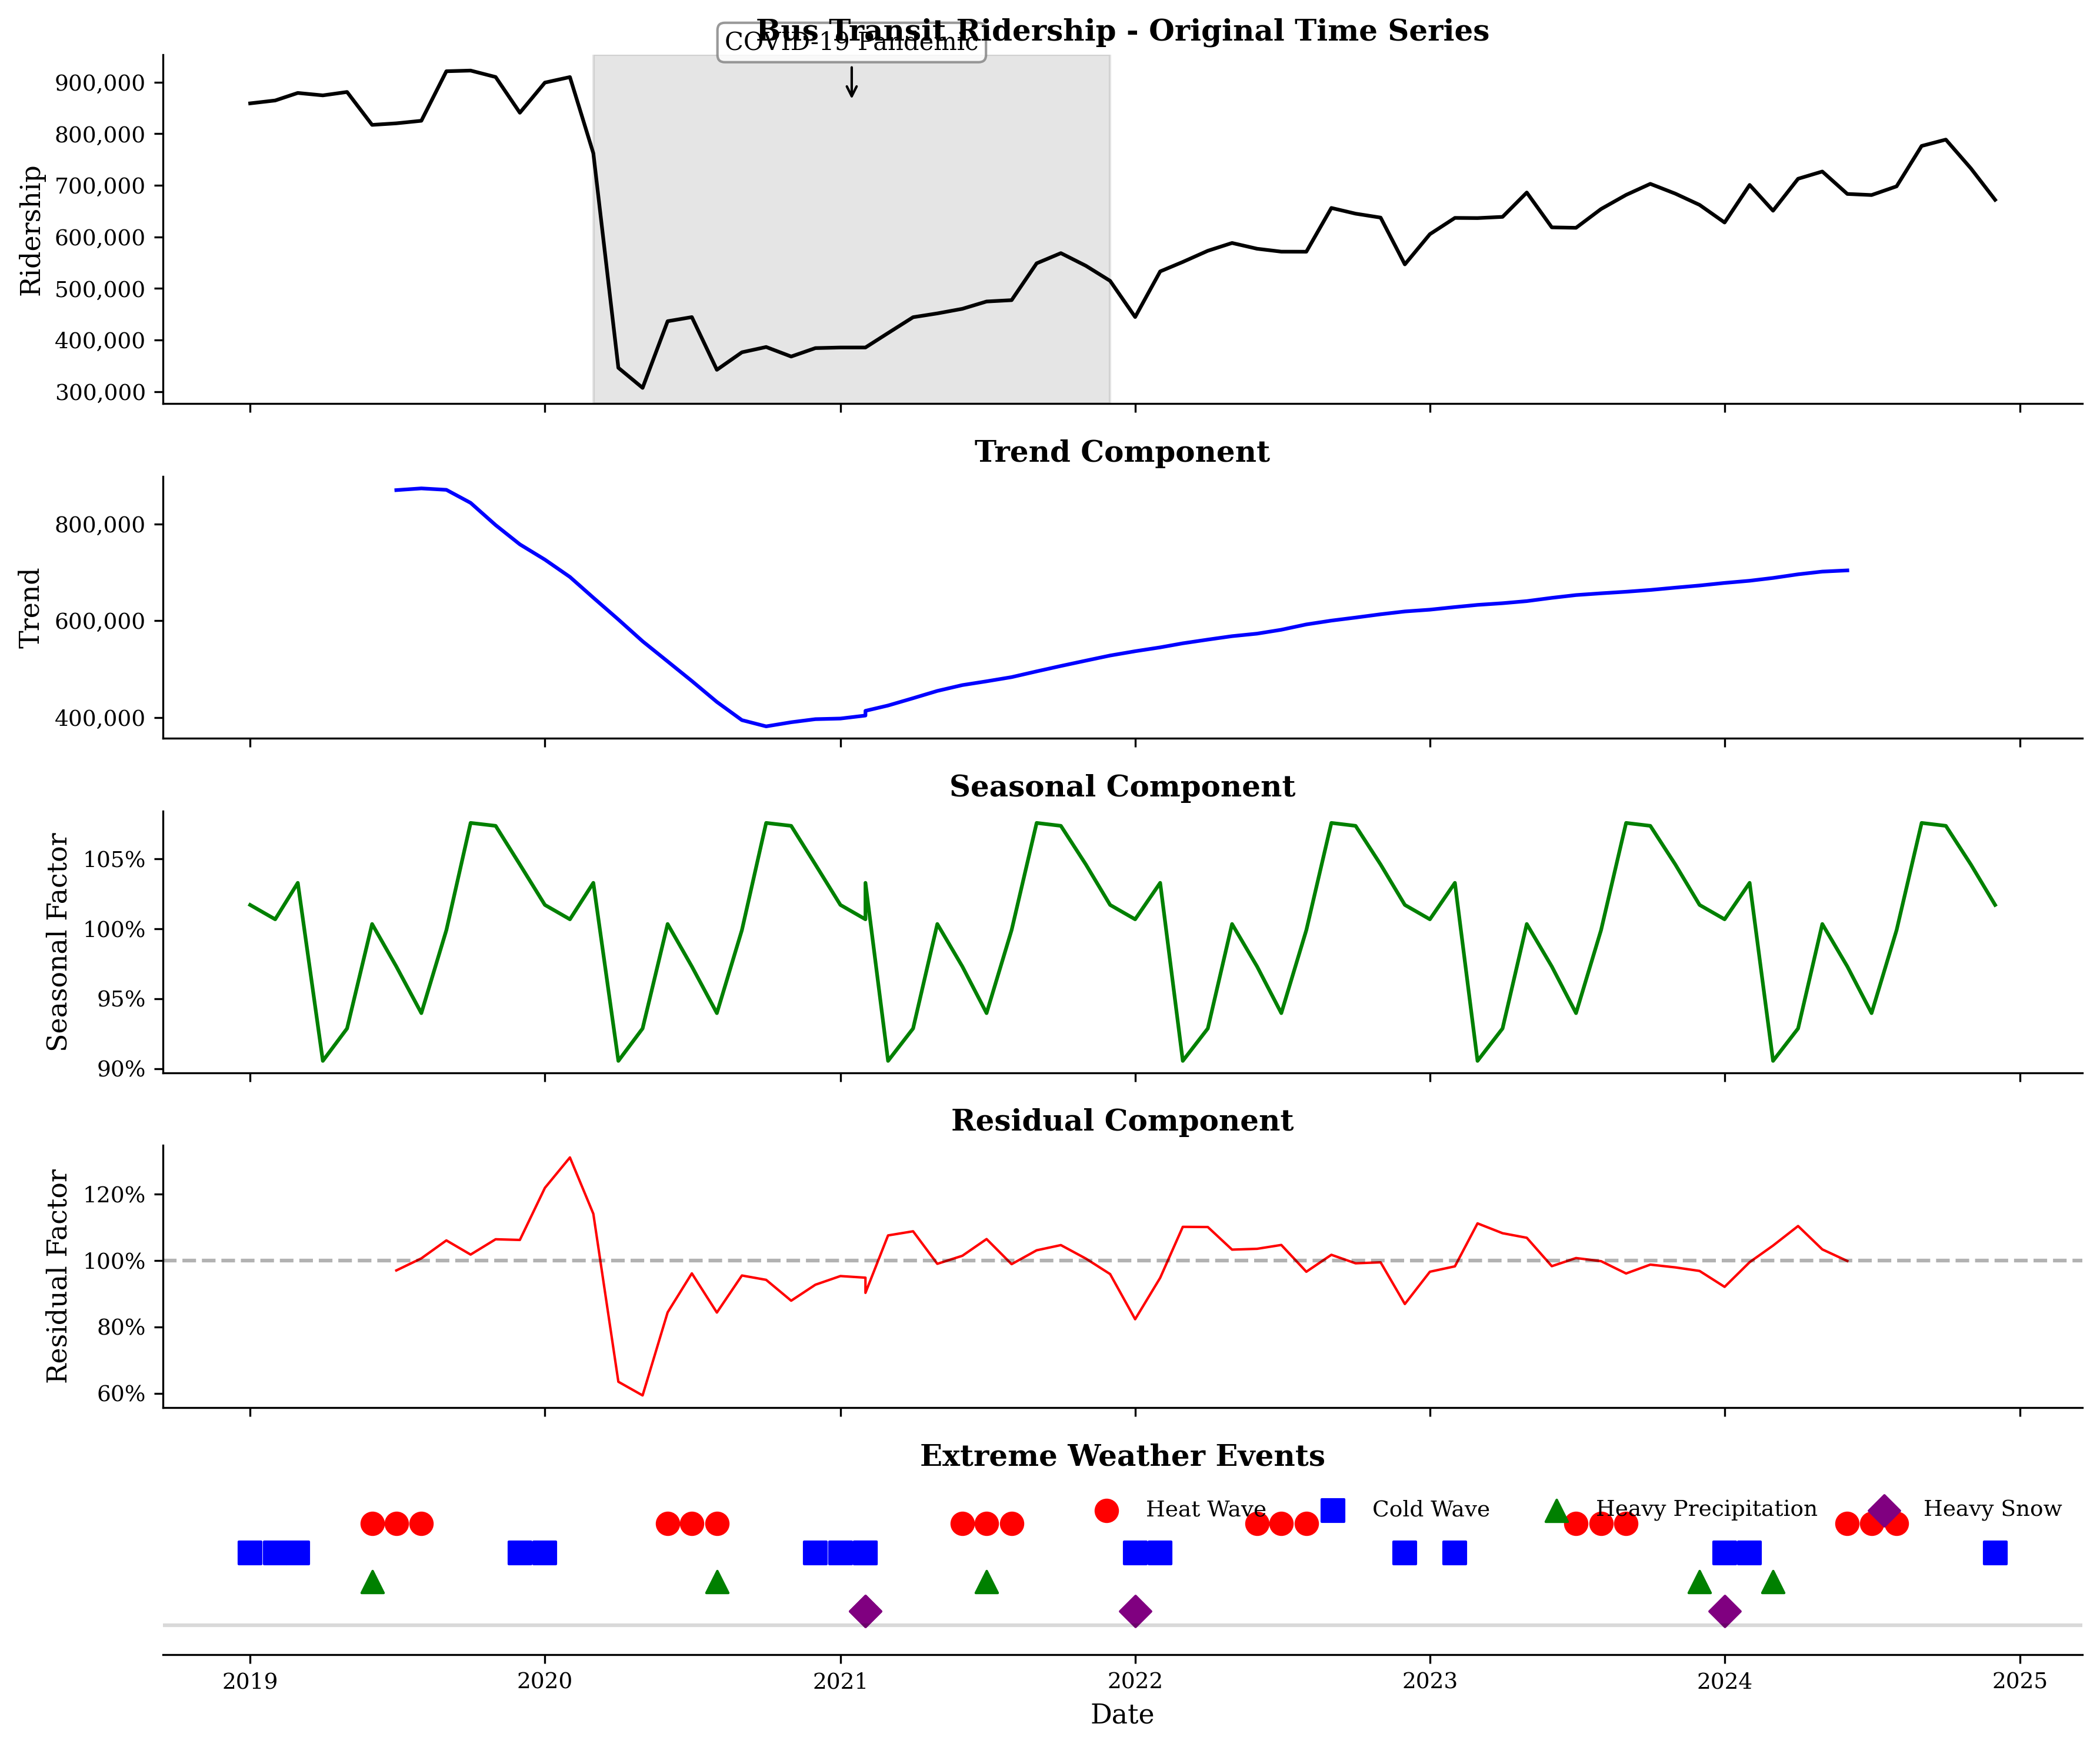


Residual Analysis for Bus:

Mean residuals during different weather conditions:
Heat Wave:
  - Mean residual during events: 0.9797
  - Mean residual during non-events: 0.9943
  - Difference: -0.0146
  - T-statistic: -0.6174, P-value: 0.5401
  - No significant difference at 5% level

Cold Wave:
  - Mean residual during events: 0.9565
  - Mean residual during non-events: 1.0007
  - Difference: -0.0441
  - T-statistic: -1.4852, P-value: 0.1504
  - No significant difference at 5% level

Heavy Precip:
  - Mean residual during events: 0.9797
  - Mean residual during non-events: 0.9916
  - Difference: -0.0119
  - T-statistic: -0.2293, P-value: 0.8314
  - No significant difference at 5% level

Heavy Snow:
  - Mean residual during events: 0.9069
  - Mean residual during non-events: 0.9997
  - Difference: -0.0927
  - T-statistic: -3.9074, P-value: 0.0020
  - Significant difference at 5% level



In [4]:
def analyze_time_series_by_mode(df, mode_name):
    """
    Perform time series decomposition analysis for a specific transit mode.

    Parameters:
    ----------
    df : pandas.DataFrame
        Dataframe with ridership data.
    mode_name : str
        Name of the transit mode to analyze.

    Returns:
    -------
    statsmodels.tsa.seasonal.DecomposeResult
        The seasonal decomposition result.
    """
    # Filter data for this mode
    mode_data = df[df['Mode'] == mode_name].copy()

    # Sort by date
    mode_data = mode_data.sort_values('Date')

    # Set date as index
    mode_data.set_index('Date', inplace=True)

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(mode_data['Ridership'], model='multiplicative', period=12)

    # Create enhanced visualization
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(5, 1, height_ratios=[4, 3, 3, 3, 2])

    # Original time series
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(mode_data.index, mode_data['Ridership'], 'k-', linewidth=1.5)

    # Add shading for pandemic period
    pandemic_data = mode_data[mode_data['Pandemic_Period'] == 'Pandemic']
    if not pandemic_data.empty:
        pandemic_start = pandemic_data.index.min()
        pandemic_end = pandemic_data.index.max()
        ax1.axvspan(pandemic_start, pandemic_end, color='gray', alpha=0.2)
        ax1.annotate('COVID-19 Pandemic',
                   xy=(pandemic_start + (pandemic_end - pandemic_start)/2,
                       ax1.get_ylim()[1]*0.9),
                   xytext=(0, 20),
                   textcoords='offset points',
                   ha='center',
                   va='bottom',
                   bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8),
                   arrowprops=dict(arrowstyle='->'))

    ax1.set_title(f'{mode_name} Transit Ridership - Original Time Series', fontweight='bold')
    ax1.set_ylabel('Ridership')
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Trend
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(decomposition.trend, 'b-', linewidth=1.5)
    ax2.set_title('Trend Component', fontweight='bold')
    ax2.set_ylabel('Trend')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Seasonality
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.plot(decomposition.seasonal, 'g-', linewidth=1.5)
    ax3.set_title('Seasonal Component', fontweight='bold')
    ax3.set_ylabel('Seasonal Factor')
    # Format y-axis as percentage
    ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)

    # Residual
    ax4 = fig.add_subplot(gs[3], sharex=ax1)
    ax4.plot(decomposition.resid, 'r-', linewidth=1)
    ax4.set_title('Residual Component', fontweight='bold')
    ax4.set_ylabel('Residual Factor')
    ax4.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    ax4.axhline(y=1, color='k', linestyle='--', alpha=0.3)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    # Weather events
    ax5 = fig.add_subplot(gs[4], sharex=ax1)
    ax5.axhline(y=0, color='k', linestyle='-', alpha=0.15)

    # Add markers for extreme weather events with better visibility
    heat_events = mode_data[mode_data['Heat_Wave_Days'] > 0]
    cold_events = mode_data[mode_data['Cold_Wave_Days'] > 0]
    precip_events = mode_data[mode_data['Heavy_Precip_Days'] > 0]
    snow_events = mode_data[mode_data['Heavy_Snow_Days'] > 0]

    # Create a vertical offset for each weather type to prevent overlap
    ax5.scatter(heat_events.index, [0.7] * len(heat_events), color='red', s=80, marker='o', label='Heat Wave')
    ax5.scatter(cold_events.index, [0.5] * len(cold_events), color='blue', s=80, marker='s', label='Cold Wave')
    ax5.scatter(precip_events.index, [0.3] * len(precip_events), color='green', s=80, marker='^', label='Heavy Precipitation')
    ax5.scatter(snow_events.index, [0.1] * len(snow_events), color='purple', s=80, marker='D', label='Heavy Snow')

    # Hide y-axis and customize y-limits
    ax5.set_yticks([])
    ax5.set_ylim(-0.2, 1.0)
    ax5.set_title('Extreme Weather Events', fontweight='bold')
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.legend(loc='upper right', ncol=4, frameon=False)

    # Format x-axis
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    ax5.set_xlabel('Date')

    plt.tight_layout()
    plt.savefig(f'fig6_{mode_name}_time_series_decomposition.png')
    plt.show()

    # Analyze residuals during weather events
    residuals = decomposition.resid.dropna()

    # Map the weather event data to the residuals
    residual_df = pd.DataFrame(residuals)
    residual_df.columns = ['residual']

    # Add weather information
    weather_df = mode_data[['Any_Heat_Wave', 'Any_Cold_Wave',
                           'Any_Heavy_Precip', 'Any_Heavy_Snow']].copy()

    # Make sure indices match up
    residual_df = pd.merge(
        residual_df,
        weather_df,
        left_index=True,
        right_index=True,
        how='left'
    )

    # Statistical analysis of residuals
    print(f"\nResidual Analysis for {mode_name}:")
    print("\nMean residuals during different weather conditions:")

    weather_types = ['Heat_Wave', 'Cold_Wave', 'Heavy_Precip', 'Heavy_Snow']
    residual_results = []

    for weather in weather_types:
        event_residuals = residual_df[residual_df[f'Any_{weather}'] == True]['residual']
        non_event_residuals = residual_df[residual_df[f'Any_{weather}'] == False]['residual']

        if len(event_residuals) > 0:
            mean_event = event_residuals.mean()
            mean_non_event = non_event_residuals.mean()

            # T-test to check if difference is significant
            t_stat, p_val = stats.ttest_ind(
                event_residuals.dropna(),
                non_event_residuals.dropna(),
                equal_var=False  # Don't assume equal variance
            )

            # Calculate effect size (Cohen's d)
            cohens_d = (mean_event - mean_non_event) / np.sqrt(
                (event_residuals.var() + non_event_residuals.var()) / 2)

            residual_results.append({
                'Mode': mode_name,
                'Weather_Event': weather.replace('_', ' '),
                'Mean_During_Event': mean_event,
                'Mean_During_Non_Event': mean_non_event,
                'Difference': mean_event - mean_non_event,
                'Percent_Difference': ((mean_event - mean_non_event) / mean_non_event) * 100,
                'T_Statistic': t_stat,
                'P_Value': p_val,
                'Cohens_d': cohens_d,
                'Sample_Size_Event': len(event_residuals),
                'Sample_Size_Non_Event': len(non_event_residuals)
            })

            print(f"{weather.replace('_', ' ')}:")
            print(f"  - Mean residual during events: {mean_event:.4f}")
            print(f"  - Mean residual during non-events: {mean_non_event:.4f}")
            print(f"  - Difference: {mean_event - mean_non_event:.4f}")
            print(f"  - T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")

            if p_val < 0.05:
                print(f"  - Significant difference at 5% level\n")
            else:
                print(f"  - No significant difference at 5% level\n")

    return decomposition, pd.DataFrame(residual_results)

# Analyze time series for bus mode as an example
bus_decomposition, bus_residual_results = analyze_time_series_by_mode(df, 'Bus')

# Initialize list to store all residual results
all_residual_results = [bus_residual_results]

# Analyze other modes too (uncomment to run for all modes)
# for mode in df['Mode'].unique():
#     if mode != 'Bus':  # Skip Bus since we already did it
#         _, mode_residual_results = analyze_time_series_by_mode(df, mode)
#         all_residual_results.append(mode_residual_results)

# Combine all residual results
# all_residual_results_df = pd.concat(all_residual_results, ignore_index=True)

In [5]:
def create_formatted_results_table(weather_impact_table):
    """Create a formatted table for the overall weather impacts."""
    # Format the table for academic presentation
    formatted_table = weather_impact_table.copy()

    # Format percentage changes with proper precision
    formatted_table['Effect (%)'] = formatted_table['Percent_Change'].round(2).astype(str) + '%'

    # Add confidence intervals
    formatted_table['95% CI'] = [
        f"[{row.CI_Lower:.2f}%, {row.CI_Upper:.2f}%]"
        for _, row in formatted_table.iterrows()
    ]

    # Add significance markers
    formatted_table['Significance'] = [
        '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        for p in formatted_table['P_Value']
    ]

    # Select and rename columns for display
    display_table = formatted_table[[
        'Weather_Event', 'Effect (%)', '95% CI', 'T_Statistic', 'P_Value', 'Significance'
    ]].copy()

    # Rename columns for better presentation
    display_table.columns = [
        'Weather Event Type', 'Effect (%)', '95% CI', 't-statistic', 'p-value', 'Significance'
    ]

    return display_table

def create_mode_specific_table(mode_summary_df):
    """Create a formatted table for mode-specific effects."""
    # Format the table
    formatted_table = mode_summary_df.copy()

    # Format percentage effects with proper precision
    formatted_table['Effect (% per day)'] = formatted_table['Pct_Effect_Per_Day'].round(2).astype(str) + '%'

    # Add confidence intervals
    formatted_table['95% CI'] = [
        f"[{row.Pct_Effect_CI_Lower:.2f}%, {row.Pct_Effect_CI_Upper:.2f}%]"
        for _, row in formatted_table.iterrows()
    ]

    # Add significance markers
    formatted_table['Significance'] = [
        '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        for p in formatted_table['P_Value']
    ]

    # Select and rename columns for display
    display_table = formatted_table[[
        'Mode', 'Weather_Event', 'Effect (% per day)', '95% CI', 'P_Value', 'Significance'
    ]].copy()

    # Rename columns for better presentation
    display_table.columns = [
        'Transit Mode', 'Weather Event', 'Effect (% per day)', '95% CI', 'p-value', 'Significance'
    ]

    # Sort by mode and then by weather event
    display_table = display_table.sort_values(['Transit Mode', 'Weather Event'])

    return display_table

# Create formatted tables
overall_results_table = create_formatted_results_table(weather_impact_table)
mode_specific_table = create_mode_specific_table(mode_summary_df)

print("\nTable 1: Overall Impact of Weather Events on Transit Ridership")
print(overall_results_table)

print("\n\nTable 2: Mode-Specific Impacts of Weather Events on Transit Ridership")
print(mode_specific_table)


Table 1: Overall Impact of Weather Events on Transit Ridership
  Weather Event Type Effect (%)              95% CI  t-statistic   p-value  \
0          Heat Wave      -7.3%   [-13.61%, -0.07%]    -2.038537  0.043300   
1          Cold Wave       6.2%    [-2.94%, 15.20%]     1.331118  0.186143   
2       Heavy Precip      2.23%    [-9.79%, 15.10%]     0.361895  0.721151   
3         Heavy Snow    -31.65%  [-40.81%, -21.40%]    -5.994759  0.000034   

  Significance  
0            *  
1           ns  
2           ns  
3          ***  


Table 2: Mode-Specific Impacts of Weather Events on Transit Ridership
         Transit Mode        Weather Event Effect (% per day)  \
1                 Bus            Cold Wave             -0.55%   
0                 Bus            Heat Wave             -0.71%   
2                 Bus  Heavy Precipitation             -1.79%   
3                 Bus           Heavy Snow             -5.14%   
5                 CCT            Cold Wave             -0.98%  